In [1]:
import yfinance as yf
import pandas as pd
import time
from datetime import datetime
import matplotlib.pyplot as plt
import squarify
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.patheffects import withStroke


In [2]:
# OMXS30 tickers information
omxs30_info = [
    {"SymbolYahoo": "ATCO-A.ST", "BaseSymbol": "ATCO", "Sector": "Industrials"},
    {"SymbolYahoo": "ATCO-B.ST", "BaseSymbol": "ATCO", "Sector": "Industrials"},
    {"SymbolYahoo": "ABB.ST",    "BaseSymbol": "ABB",  "Sector": "Industrials"},
    {"SymbolYahoo": "AZN.ST",    "BaseSymbol": "AZN",  "Sector": "Health Care"},
    {"SymbolYahoo": "INVE-B.ST", "BaseSymbol": "INVE", "Sector": "Financials"},
    {"SymbolYahoo": "VOLV-B.ST", "BaseSymbol": "VOLV", "Sector": "Industrials"},
    {"SymbolYahoo": "NDA-SE.ST", "BaseSymbol": "NDA",  "Sector": "Financials"},
    {"SymbolYahoo": "ASSA-B.ST", "BaseSymbol": "ASSA", "Sector": "Industrials"},
    {"SymbolYahoo": "SEB-A.ST",  "BaseSymbol": "SEB",  "Sector": "Financials"},
    {"SymbolYahoo": "ERIC-B.ST", "BaseSymbol": "ERIC", "Sector": "Telecommunications"},
    {"SymbolYahoo": "HEXA-B.ST", "BaseSymbol": "HEXA", "Sector": "Technology"},
    {"SymbolYahoo": "SWED-A.ST", "BaseSymbol": "SWED", "Sector": "Financials"},
    {"SymbolYahoo": "SAND.ST",   "BaseSymbol": "SAND", "Sector": "Industrials"},
    {"SymbolYahoo": "SHB-A.ST",  "BaseSymbol": "SHB",  "Sector": "Financials"},
    {"SymbolYahoo": "HM-B.ST",   "BaseSymbol": "HM",   "Sector": "Consumer Discretionary"},
    {"SymbolYahoo": "ESSITY-B.ST", "BaseSymbol": "ESSITY", "Sector": "Consumer Staples"},
    {"SymbolYahoo": "ALFA.ST",   "BaseSymbol": "ALFA", "Sector": "Industrials"},
    {"SymbolYahoo": "EVO.ST",    "BaseSymbol": "EVO",  "Sector": "Technology"},
    {"SymbolYahoo": "SAAB-B.ST", "BaseSymbol": "SAAB", "Sector": "Industrials"},
    {"SymbolYahoo": "TELIA.ST",  "BaseSymbol": "TELIA","Sector": "Telecommunications"},
    {"SymbolYahoo": "SKF-B.ST",  "BaseSymbol": "SKF",  "Sector": "Industrials"},
    {"SymbolYahoo": "SCA-B.ST",  "BaseSymbol": "SCA",  "Sector": "Basic Materials"},
    {"SymbolYahoo": "BOL.ST",    "BaseSymbol": "BOL",  "Sector": "Basic Materials"},
    {"SymbolYahoo": "NIBE-B.ST", "BaseSymbol": "NIBE", "Sector": "Industrials"},
    {"SymbolYahoo": "TEL2-B.ST", "BaseSymbol": "TEL2", "Sector": "Telecommunications"},
    {"SymbolYahoo": "GETI-B.ST", "BaseSymbol": "GETI", "Sector": "Health Care"},
    {"SymbolYahoo": "ELUX-B.ST", "BaseSymbol": "ELUX", "Sector": "Consumer Discretionary"},
    {"SymbolYahoo": "KINV-B.ST", "BaseSymbol": "KINV", "Sector": "Financials"},
    {"SymbolYahoo": "SINCH.ST",  "BaseSymbol": "SINCH","Sector": "Technology"},
    {"SymbolYahoo": "SBB-B.ST",  "BaseSymbol": "SBB",  "Sector": "Real Estate"}
]


from datetime import datetime, timedelta
def fetch_data_for_date_range(omxs30_symbols, start_date, end_date):
    """
    Fetch market data between a given date range and calculate percentage changes.
    Raises an error if no valid trading data exists for the specified range.
    """
    data = []

    for symbol in omxs30_symbols:
        try:
            print(f"Fetching data for {symbol}...")

            # Retrieve stock info for market cap
            stock = yf.Ticker(symbol)
            info = stock.info
            market_cap = info.get("marketCap", None)  #Fetch MarketCap

            # Download data for the given date range
            stock_data = yf.download(symbol, start=start_date, end=end_date, interval="1d", progress=False)

            if stock_data.empty:
                raise ValueError(f"No trading data available for {symbol} between {start_date} and {end_date}")

            # Find the first and last valid trading days
            close_start = stock_data["Close"].iloc[0] if not stock_data["Close"].isna().iloc[0] else None
            close_end = stock_data["Close"].iloc[-1] if not stock_data["Close"].isna().iloc[-1] else None

            # Validate data availability within the range
            if close_start is None or close_end is None:
                raise ValueError(f"Invalid trading data for {symbol} in the range {start_date} to {end_date}")

            # Debug: Print close_start and close_end
            print(f"{symbol} - Close Start: {close_start}, Close End: {close_end}")

            # Calculate percentage change
            pct_change = ((close_end - close_start) / close_start) * 100

            # Append to data
            data.append({
                "Symbol": symbol,
                "MarketCap": market_cap,
                "CloseStart": close_start,
                "CloseEnd": close_end,
                "PctChange": pct_change
            })

        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            data.append({
                "Symbol": symbol,
                "MarketCap": None,
                "CloseStart": None,
                "CloseEnd": None,
                "PctChange": None,
                "Error": str(e)
            })

        time.sleep(1)

    return pd.DataFrame(data)

In [3]:
def generate_treemap_for_date_range(omxs30_symbols, omxs30_info, start_date, end_date, custom_title=None):
    """
    Generate a treemap for a given date range.
    Allows an optional custom title for the treemap.
    """
    df_pct_change = fetch_data_for_date_range(omxs30_symbols, start_date, end_date)
    df_info = pd.DataFrame(omxs30_info)
    df_combined = pd.merge(df_info, df_pct_change, left_on="SymbolYahoo", right_on="Symbol", how="left")

    # Combine duplicates
    df_combined["SumMarketCap"] = df_combined["MarketCap"]
    df_combined["WeightedPctChange"] = df_combined["PctChange"]
    df_combined = (
        df_combined
        .groupby(["BaseSymbol", "Sector"], as_index=False)
        .agg({
            "SumMarketCap": "sum",
            "WeightedPctChange": "mean",
        })
    )

    # Generate the treemap
    plot_omxs30_treemap_instagram(df_combined, start_date, end_date, custom_title)
    
def plot_omxs30_treemap_instagram(df_combined, start_date, end_date, custom_title=None):
    """
    Create a treemap with black background, white inner lines, and black sector lines.
    """
    sector_agg = (
        df_combined
        .groupby("Sector", as_index=False)["SumMarketCap"]
        .sum()
        .rename(columns={"SumMarketCap": "TotalSectorMcap"})
        .sort_values("TotalSectorMcap", ascending=False)
    )

    total_market_cap = sector_agg["TotalSectorMcap"].sum()
    sector_sizes = sector_agg["TotalSectorMcap"].values / total_market_cap * (100 * 100)
    sector_names = sector_agg["Sector"].values
    sector_rects = squarify.squarify(sector_sizes, 0, 0, 100, 100)

    # Use actual data range for normalization
    min_chg = df_combined["WeightedPctChange"].min()
    max_chg = df_combined["WeightedPctChange"].max()

    # Define colormaps
    light_red_to_red = LinearSegmentedColormap.from_list("light_red_to_red", ["#FF0000", "#FFCCCC"])
    light_green_to_strong_green = LinearSegmentedColormap.from_list("light_green_to_strong_green", ["#CCFFCC", "#009900"])

    # Define normalizers based on the data
    norm_neg = mcolors.Normalize(vmin=min_chg, vmax=0)  # For negative values
    norm_pos = mcolors.Normalize(vmin=0, vmax=max_chg)  # For positive values

    # Set up the black theme
    black_background_color = "#FFFFFF"  # Fully black
    inner_line_color = "#FFFFFF"  # White for inner lines
    sector_line_color = "#000000"  # Black for sector lines
    fig, ax = plt.subplots(figsize=(10.8, 19.2), facecolor=black_background_color)  # Set figure background
    ax.set_facecolor(black_background_color)  # Set axes background
    margin = 1
    ax.set_xlim(-margin, 100 + margin)
    ax.set_ylim(-margin, 103 + margin)
    ax.axis("off")

    for srect, sector_name in zip(sector_rects, sector_names):
        subdf = df_combined[df_combined["Sector"] == sector_name]
        sub_total_market_cap = subdf["SumMarketCap"].sum()
        sub_sizes = subdf["SumMarketCap"].values / sub_total_market_cap * (srect["dx"] * srect["dy"])
        sub_rects = squarify.squarify(sub_sizes, srect["x"], srect["y"], srect["dx"], srect["dy"])

        for sbox, row in zip(sub_rects, subdf.itertuples()):
            chg_val = row.WeightedPctChange
            # Apply normalization based on the change value
            if chg_val >= 0:
                color_rgba = light_green_to_strong_green(norm_pos(chg_val))  # Positive gradient
            else:
                color_rgba = light_red_to_red(norm_neg(chg_val))  # Negative gradient

            ax.add_patch(plt.Rectangle(
                (sbox["x"], sbox["y"]), sbox["dx"], sbox["dy"], 
                facecolor=color_rgba, edgecolor=inner_line_color, linewidth=1
            ))

            if sbox["dx"] * sbox["dy"] > 2: #inreasing this will remove text over tiny boxes
                sym = row.BaseSymbol
                label_str = f"{sym}\n{chg_val:.2f}%"
                ax.text(
                    sbox["x"] + sbox["dx"] / 2,
                    sbox["y"] + sbox["dy"] / 2,
                    label_str,
                    ha="center", va="center",
                    fontsize=12, fontweight="bold",
                    color="white",  # White font for labels
                    path_effects=[withStroke(linewidth=2, foreground="black")]  # Black outline for better contrast
                )

        # Add black sector boundary lines
        ax.add_patch(
            plt.Rectangle((srect["x"], srect["y"]), srect["dx"], srect["dy"], fill=False, edgecolor=sector_line_color, linewidth=2)
        )

    # Add title
    final_title = custom_title if custom_title else f"OMXS30 Treemap ({start_date} to {end_date})"
    fig.suptitle(final_title, fontsize=24, fontweight="bold", color="k", y=0.96)

    # Save and display plot
    plt.tight_layout()
    plt.savefig(
        f'OMXS30_Treemap_{custom_title}.png',
        dpi=800,
        bbox_inches="tight",
        facecolor=fig.get_facecolor(),  # Ensure black background is applied to the saved image
    )
    plt.show()



## sector heatmap

In [4]:
from datetime import datetime

def plot_omxs30_sector_treemap_weekly(df_combined, start_date, end_date):
    """
    Create a treemap where each sector's area is proportional to its total market capitalization,
    and the label shows the sector name and its average weekly percentage change with a custom font.
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.patheffects import withStroke
    import squarify
    import matplotlib.colors as mcolors

    # Ensure necessary columns exist
    required_columns = {"Sector", "SumMarketCap", "WeightedWeeklyChange"}
    if not required_columns.issubset(df_combined.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(df_combined.columns)}")

    # Check for non-empty data
    if df_combined.empty:
        raise ValueError("The provided DataFrame is empty.")

    # Aggregate data by sector
    sector_agg = (
        df_combined
        .groupby("Sector", as_index=False)
        .agg({
            "SumMarketCap": "sum",  # Sum market caps
            "WeightedWeeklyChange": "mean",  # Average percentage change
        })
        .sort_values("SumMarketCap", ascending=False)
    )

    # Normalize sector sizes to fit within the plot bounds
    total_market_cap = sector_agg["SumMarketCap"].sum()
    if total_market_cap == 0:
        raise ValueError("Total market capitalization is zero. Check the data for correctness.")

    sector_sizes = sector_agg["SumMarketCap"].values / total_market_cap * (100 * 100)
    sector_names = sector_agg["Sector"].values
    sector_changes = sector_agg["WeightedWeeklyChange"].values
    sector_rects = squarify.squarify(sector_sizes, 0, 0, 100, 100)

    # Shorten sector names for clarity
    short_sector_names = {
        "Consumer Discretionary": "Cons. Disc.",
        "Consumer Staples": "Cons. Stap.",
        "Health Care": "Health",
        "Telecommunications": "Telecom",
        "Basic Materials": "Materials",
        "Financials": "Finance",
        "Industrials": "Industry",
        "Real Estate": "Real Est."
    }
    sector_names_short = [short_sector_names.get(name, name) for name in sector_names]

    # Find min and max change for coloring
    min_chg = sector_agg["WeightedWeeklyChange"].min()
    max_chg = sector_agg["WeightedWeeklyChange"].max()

    # Two custom gradients: red-ish for negative, green-ish for positive
    light_red_to_red = LinearSegmentedColormap.from_list(
        "light_red_to_red", ["#FF0000", "#FFCCCC"]
    )
    light_green_to_strong_green = LinearSegmentedColormap.from_list(
        "light_green_to_strong_green", ["#CCFFCC", "#009900"]
    )

    # Normalizers for negative and positive changes
    norm_neg = mcolors.Normalize(vmin=min_chg, vmax=0)
    norm_pos = mcolors.Normalize(vmin=0, vmax=max_chg)

    # Determine the ISO week number for the title
    start_date_obj = datetime.strptime(start_date, "%Y-%m-%d")
    week_number = start_date_obj.isocalendar()[1]
    title = f" OMXS30 Week {week_number}, 2025 Sector"

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10.8, 19.2))  # Adjusted size for better layout

    # Add margins
    margin = 1
    ax.set_xlim(-margin, 100 + margin)
    ax.set_ylim(-margin, 103 + margin)
    ax.axis("off")

    # Plot each sector rectangle
    for srect, sector_name, sector_change in zip(sector_rects, sector_names_short, sector_changes):
        # Decide which colormap (negative or positive)
        if sector_change >= 0:
            color_rgba = light_green_to_strong_green(norm_pos(sector_change))
        else:
            color_rgba = light_red_to_red(norm_neg(sector_change))

        # Draw rectangle with a dark black frame
        ax.add_patch(
            plt.Rectangle(
                (srect["x"], srect["y"]), srect["dx"], srect["dy"],
                facecolor=color_rgba, edgecolor="black", linewidth=2
            )
        )

        # Increase font size for better visibility
        font_size = max(13, min(18, int(srect["dx"] * srect["dy"] ** 0.5 / 40)))

        # Add sector name and average percentage change
        label_str = f"{sector_name}\n{sector_change:.2f}%"
        ax.text(
            srect["x"] + srect["dx"] / 2,
            srect["y"] + srect["dy"] / 2,
            label_str,
            ha="center", va="center",
            fontsize=font_size, fontweight="bold",
            color="white",
            path_effects=[withStroke(linewidth=2, foreground="black")]
        )

    # Add title and control its position
    fig.suptitle(
        title,
        fontsize=24, fontweight="bold", y=0.96
    )

    # Save and show plot
    plt.tight_layout()
    plt.savefig(f'OMXS30_Sector_HeatMap_{title}.png', dpi=800, bbox_inches="tight")
    plt.show()


#### week 1

In [5]:

# generate_treemap_for_date_range(
#     [info["SymbolYahoo"] for info in omxs30_info],
#     omxs30_info,
#     start_date="2025-01-02",
#     end_date="2025-01-04",
#     custom_title="OMXS30 Week 1, 2025"
# )

#### week 2

In [6]:
# # Example Usage
# generate_treemap_for_date_range(
#     [info["SymbolYahoo"] for info in omxs30_info],
#     omxs30_info,
#     start_date="2025-01-07",
#     end_date="2025-01-11", 
#     custom_title="OMXS30 Week 2, 2025"
# )

#### week 3

In [7]:
# # Example Usage
# generate_treemap_for_date_range(
#     [info["SymbolYahoo"] for info in omxs30_info],
#     omxs30_info,
#     start_date="2025-01-13",
#     end_date="2025-01-18",
#     custom_title="OMXS30 Week 3, 2025"
# )


#### week 4

Fetching data for ATCO-A.ST...
ATCO-A.ST - Close Start: 185.8000030517578, Close End: 192.39999389648438
Fetching data for ATCO-B.ST...
ATCO-B.ST - Close Start: 166.3000030517578, Close End: 173.0500030517578
Fetching data for ABB.ST...
ABB.ST - Close Start: 617.0, Close End: 650.5999755859375
Fetching data for AZN.ST...
AZN.ST - Close Start: 1471.5, Close End: 1511.5
Fetching data for INVE-B.ST...
INVE-B.ST - Close Start: 311.3500061035156, Close End: 315.20001220703125
Fetching data for VOLV-B.ST...
VOLV-B.ST - Close Start: 288.1000061035156, Close End: 293.29998779296875
Fetching data for NDA-SE.ST...
NDA-SE.ST - Close Start: 128.8000030517578, Close End: 132.85000610351562
Fetching data for ASSA-B.ST...
ASSA-B.ST - Close Start: 336.20001220703125, Close End: 338.0
Fetching data for SEB-A.ST...
SEB-A.ST - Close Start: 160.4499969482422, Close End: 165.25
Fetching data for ERIC-B.ST...
ERIC-B.ST - Close Start: 95.08000183105469, Close End: 85.19999694824219
Fetching data for HEXA-B.S

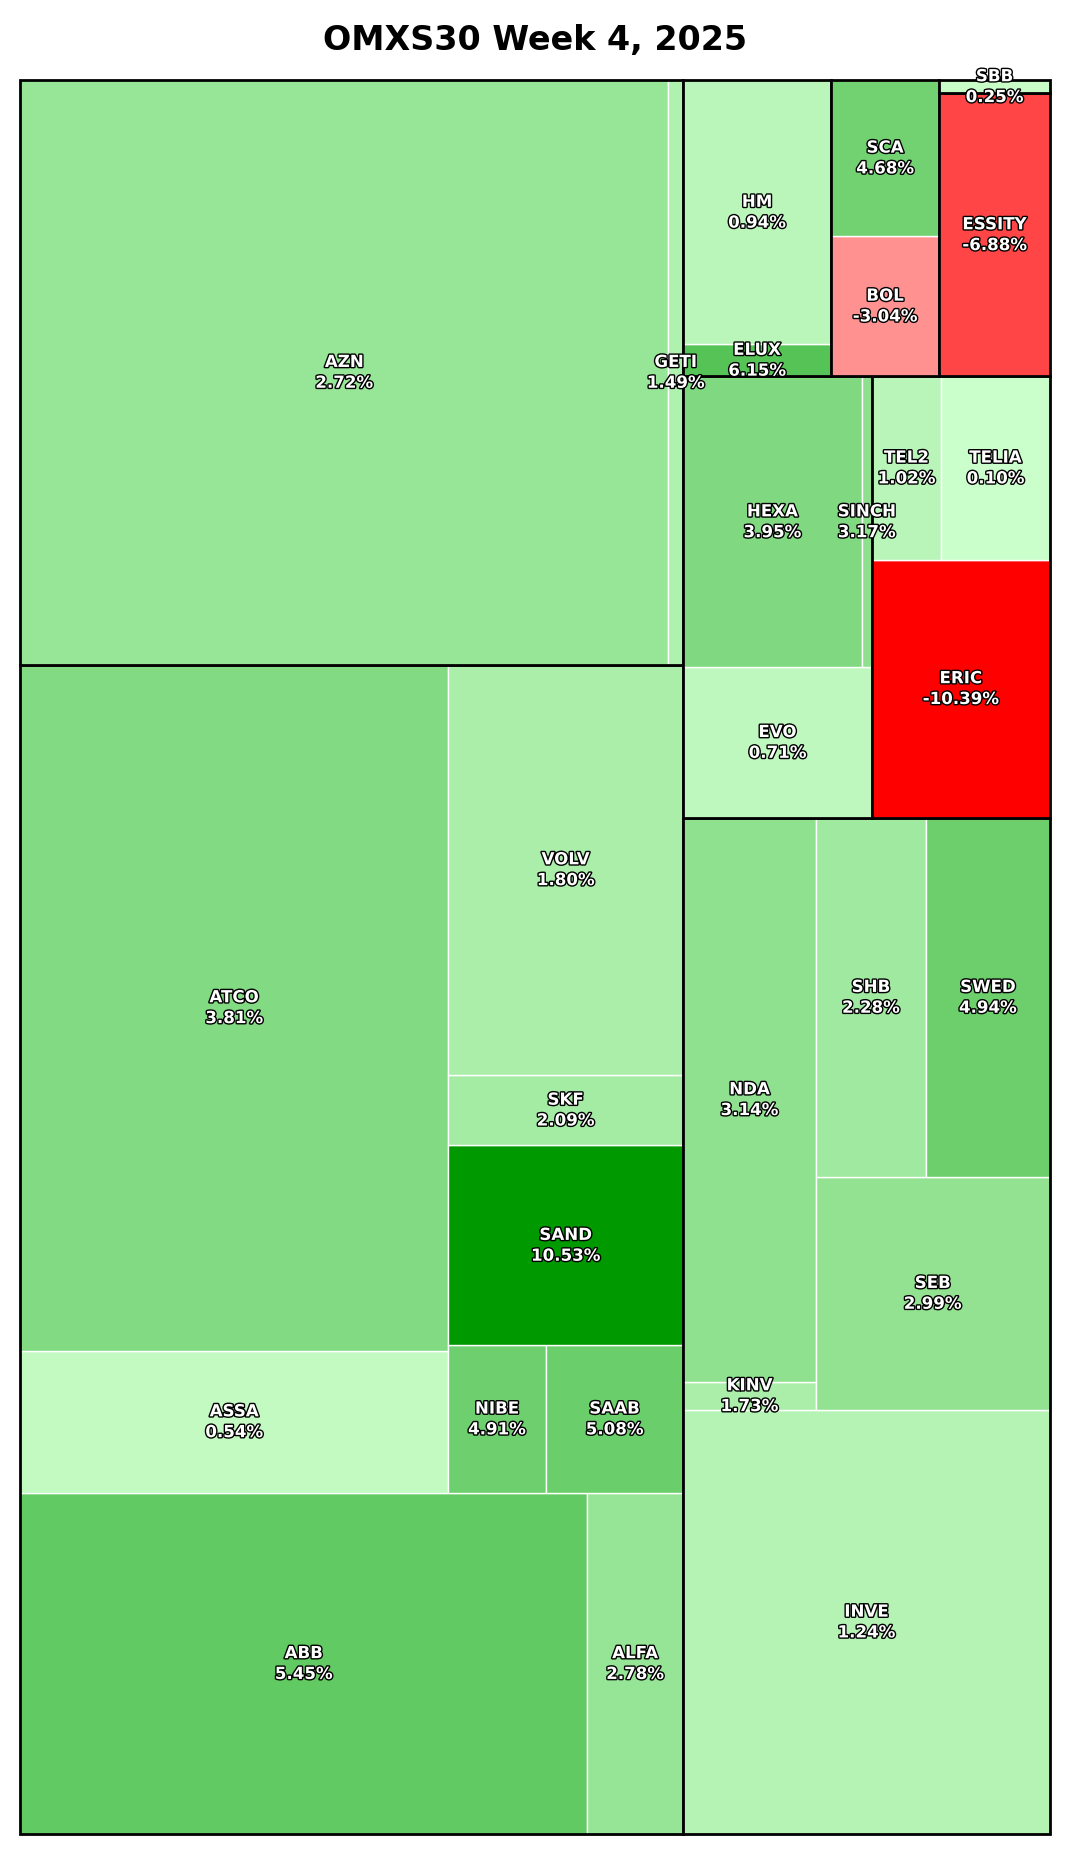

In [8]:
# Example Usage
generate_treemap_for_date_range(
    [info["SymbolYahoo"] for info in omxs30_info],
    omxs30_info,
    start_date="2025-01-20",
    end_date="2025-01-26",
    custom_title="OMXS30 Week 4, 2025"
)

Fetching data for ATCO-A.ST...
ATCO-A.ST - Close Start: 185.8000030517578, Close End: 192.39999389648438
Fetching data for ATCO-B.ST...
ATCO-B.ST - Close Start: 166.3000030517578, Close End: 173.0500030517578
Fetching data for ABB.ST...
ABB.ST - Close Start: 617.0, Close End: 650.5999755859375
Fetching data for AZN.ST...
AZN.ST - Close Start: 1471.5, Close End: 1511.5
Fetching data for INVE-B.ST...
INVE-B.ST - Close Start: 311.3500061035156, Close End: 315.20001220703125
Fetching data for VOLV-B.ST...
VOLV-B.ST - Close Start: 288.1000061035156, Close End: 293.29998779296875
Fetching data for NDA-SE.ST...
NDA-SE.ST - Close Start: 128.8000030517578, Close End: 132.85000610351562
Fetching data for ASSA-B.ST...
ASSA-B.ST - Close Start: 336.20001220703125, Close End: 338.0
Fetching data for SEB-A.ST...
SEB-A.ST - Close Start: 160.4499969482422, Close End: 165.25
Fetching data for ERIC-B.ST...
ERIC-B.ST - Close Start: 95.08000183105469, Close End: 85.19999694824219
Fetching data for HEXA-B.S

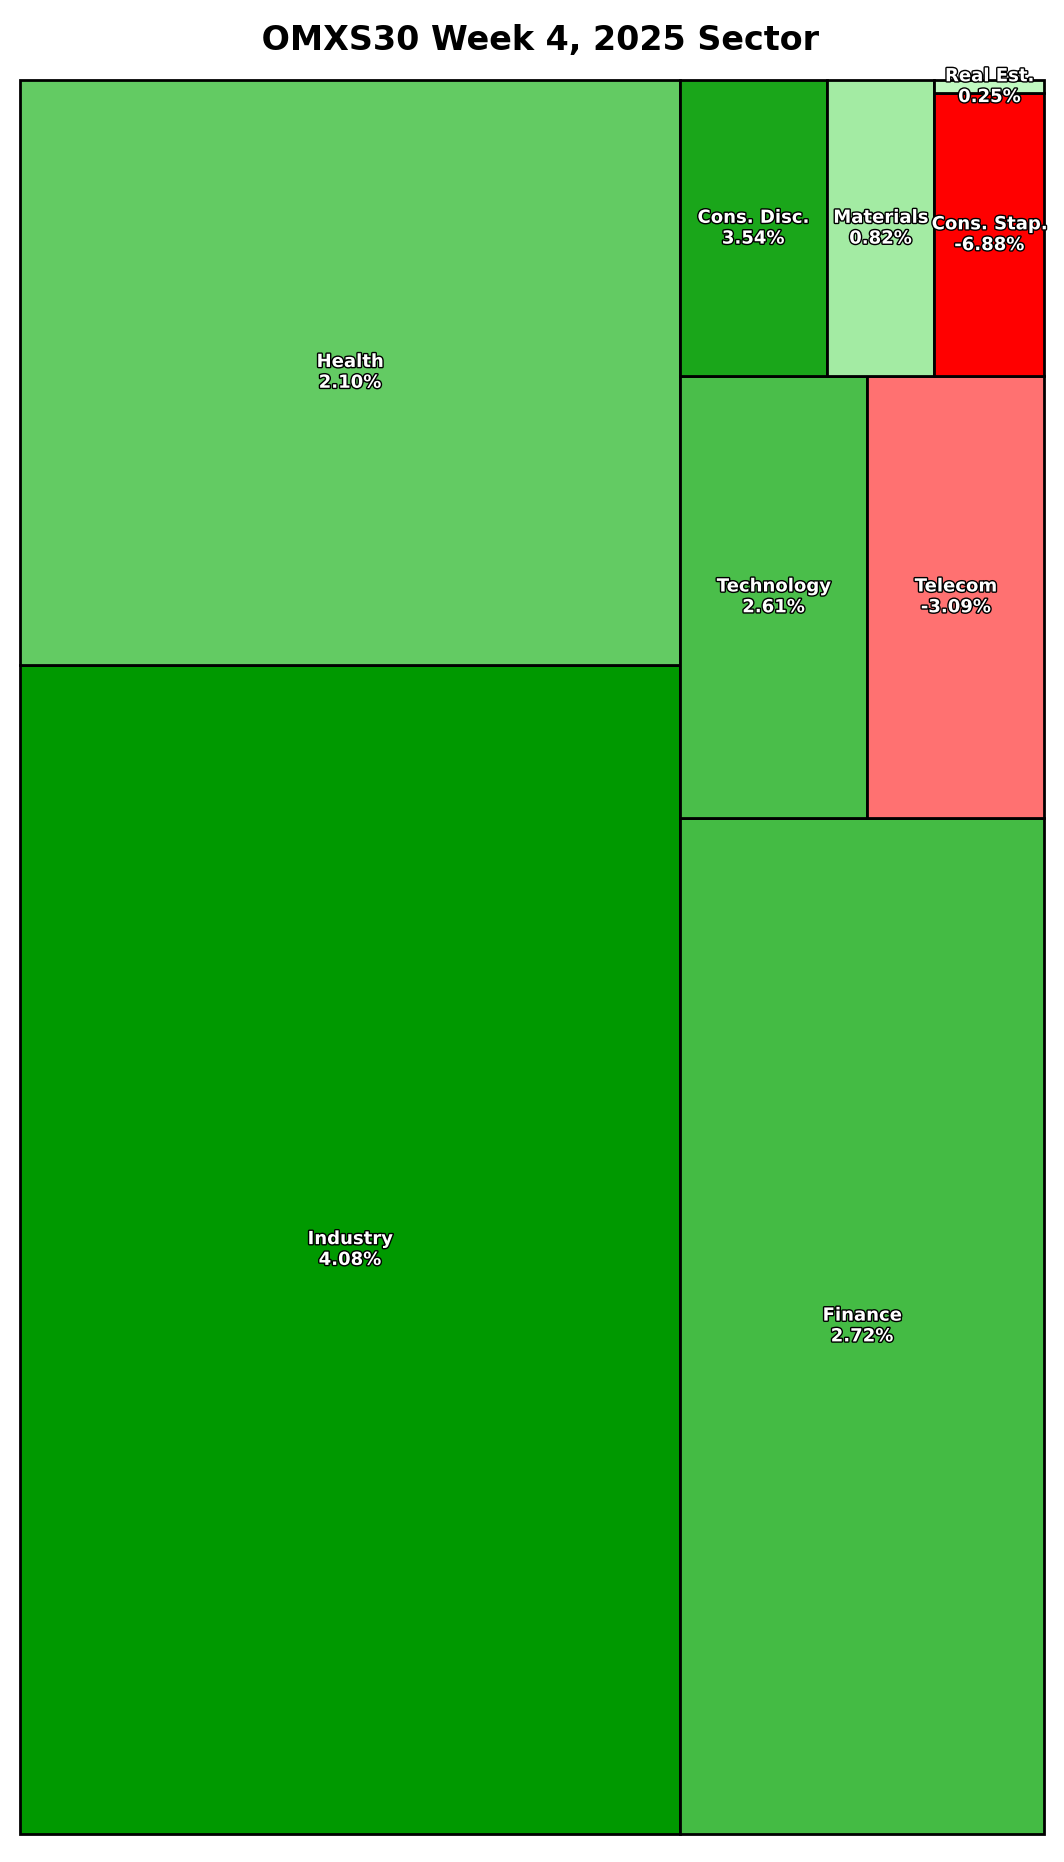

In [9]:
# Define the date range for the week
start_date = "2025-01-20"
end_date = "2025-01-25"

# Fetch data and generate the heatmap
try:
    # Extract symbols from the provided OMXS30 information
    omxs30_symbols = [info["SymbolYahoo"] for info in omxs30_info]

    # Fetch data for the specified date range
    df_pct_change = fetch_data_for_date_range(omxs30_symbols, start_date, end_date)

    # Combine the fetched data with sector information
    df_info = pd.DataFrame(omxs30_info)
    df_combined = pd.merge(
        df_info, df_pct_change,
        left_on="SymbolYahoo", right_on="Symbol", how="left"
    )

    # Aggregate data for plotting
    df_combined["SumMarketCap"] = df_combined["MarketCap"]
    df_combined["WeightedWeeklyChange"] = df_combined["PctChange"]
    df_combined = (
        df_combined
        .groupby("Sector", as_index=False)
        .agg({
            "SumMarketCap": "sum",        # Total market cap by sector
            "WeightedWeeklyChange": "mean"  # Average weekly percentage change by sector
        })
    )

    # Generate the heatmap for the specified week
    plot_omxs30_sector_treemap_weekly(df_combined, start_date, end_date)

except Exception as e:
    print(f"An error occurred: {e}")
